In [248]:

import matplotlib.pyplot as plt
import scipy as sy
import numpy as np
from math import sqrt, log
from tqdm import tqdm

# Tomography

In [345]:
fidelities = {}
nshots = {}
noisy_fidelities_Brisbane = {}
noisy_fidelities_Sherbrooke = {}
noisy_fidelities_Kyiv = {}

Range_tomo = np.arange(2, 7)
for i in Range_tomo:
    fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}.dat' 
    if i==4:
        fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}_log.dat' 
    elif i==5:
        fn = f'data/fidelities_n={i}_range={100}_{200}_{30000}_{35000}_{5000}_{100000}_log.dat' 
    elif i==6:
        fn = f'data/fidelities_n={i}_range={100}_{300}_{95000}_log.dat' 

    with open(fn, 'r') as f:
        data = np.loadtxt(f)
        tmp_nshots = data[:, 0]
        tmp_fidelities = data[:, 1]
        tmp_noisy_fidelities_Brisbane = data[:, 2]
        tmp_noisy_fidelities_Sherbrooke = data[:, 3]
        tmp_noisy_fidelities_Kyiv = data[:, 4]
    # plt.plot(nshots, fidelities, label=f'{i} noiseless')
    # plt.plot(nshots, noisy_fidelities_Brisbane, label=f'{i} Brisbane')
    # plt.plot(nshots, noisy_fidelities_Kyiv, '--', label=f'{i} Kyiv')
    # plt.plot(nshots, noisy_fidelities_Sherbrooke, label=f'{i} Sherbrooke')
    # plt.xscale('log')
    nshots[i] = tmp_nshots
    fidelities[i] = tmp_fidelities
    noisy_fidelities_Brisbane[i] = tmp_noisy_fidelities_Brisbane
    noisy_fidelities_Sherbrooke[i] = tmp_noisy_fidelities_Sherbrooke
    noisy_fidelities_Kyiv[i] = tmp_noisy_fidelities_Kyiv



In [323]:
super_fid_tomo = {'Noiseless QASM simulator': fidelities, 'Brisbane backend': noisy_fidelities_Brisbane, 'Kyiv backend': noisy_fidelities_Kyiv, 'Sherbrooke backend': noisy_fidelities_Sherbrooke}

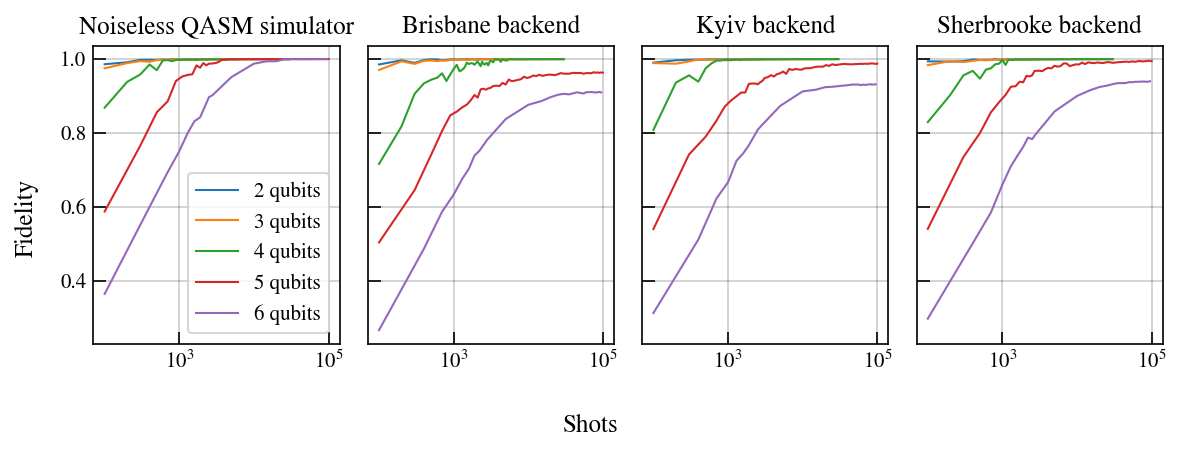

In [325]:
plt.style.use('style_v1.mplstyle')

fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(8,3))

i = 0
for name, vals in super_fid_tomo.items():
    for j in Range_tomo:
        axs[i].semilogx(nshots[j], vals[j], label=f'{j} qubits')
    axs[i].set_title(name)
    axs[i].grid()
    i += 1

axs[0].legend()
fig.supylabel('Fidelity')
fig.supxlabel('Shots')
fig.tight_layout()
fig.savefig('plots/tot_comparison.pdf')

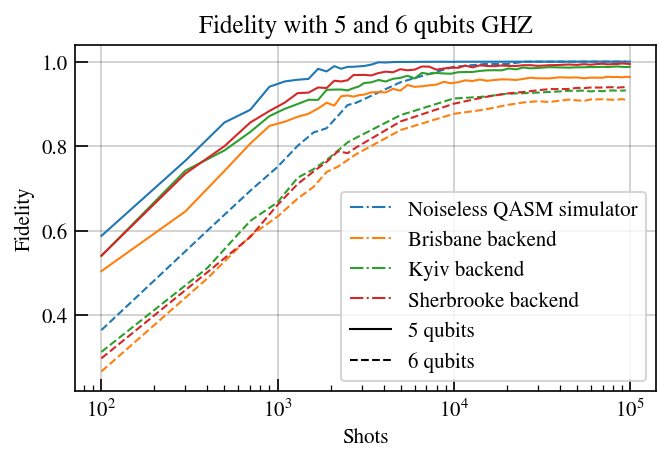

In [327]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
i = 0
for name, vals in super_fid_tomo.items():
    plt.semilogx(nshots[6], vals[6], '--', color=colors[i])#, label=f'6 qubits {name}')
    plt.semilogx(nshots[5], vals[5], '-', color=colors[i])#, label=f'5 qubits {name}')
    plt.semilogx(1e3, 0, '-.', color=colors[i], label=f'{name}')
    i+=1


plt.semilogx(1e3, 0, 'k-', label=f'5 qubits')
plt.semilogx(1e3, 0, 'k--', label=f'6 qubits')

plt.title('Fidelity with 5 and 6 qubits GHZ')
plt.legend()
plt.ylabel('Fidelity')
plt.xlabel('Shots')
plt.ylim(0.22, 1.04)
plt.grid()
plt.savefig('plots/tomo_5vs6.pdf')

In [328]:
threshold = 0.95
min_nshots = {}
for name, vals in super_fid_tomo.items():
    tmp_min_shots = []
    for i in Range_tomo:
        try:
            idx = np.argwhere(vals[i]>threshold)[0][0]
            tmp_min_shots.append(nshots[i][idx])
        except Exception:
            tmp_min_shots.append(-1)
    min_nshots[name] = np.array(tmp_min_shots)

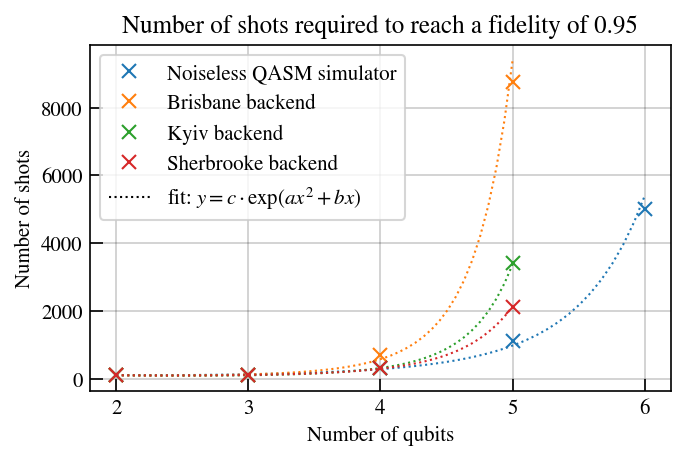

In [329]:
i = 0
for name, vals in min_nshots.items():
    fit = np.polyfit(Range_tomo[vals>0], np.log(vals[vals>0]), 2)
    x = np.linspace(2, len(vals[vals>0])+1)
    fit_vals = np.polyval(fit, x)
    plt.plot(Range_tomo[vals>0], vals[vals>0], 'x', markersize=7, color=colors[i], label=f'{name}')
    plt.plot(x, np.exp(fit_vals), ':', markersize=7, color=colors[i])
    i += 1

plt.plot(2, 1000, 'k:', label=r'fit: $y=c\cdot\exp(ax^2+bx)$')

plt.title(f'Number of shots required to reach a fidelity of {threshold}')
plt.xlabel('Number of qubits')
plt.ylabel('Number of shots')
plt.xticks(Range_tomo)
plt.legend()
# plt.ylim(0, 2000)
plt.grid()
plt.savefig('plots/shots_required_0.95.pdf')

# Classical shadows

In [330]:
clsh = {}
noisy_clsh = {}
nshots = []

Range = np.concatenate((np.arange(2, 8), [18, 20]))

for i in Range:
    if i==4 or i==6:
        fn_QASM = f'data/fidelities_n={i}_N=8000_QASM_bis.dat' 
        fn_Br = f'data/fidelities_n={i}_N=8000_Br_bis.dat' 
    else:
        fn_QASM = f'data/fidelities_n={i}_N=8000_QASM.dat' 
        fn_Br = f'data/fidelities_n={i}_N=8000_Br.dat' 
   
    with open(fn_QASM, 'r') as f:
        tmp_clsh = np.loadtxt(f)

    with open(fn_QASM, 'r') as f:
        tmp_noisy_clsh = np.loadtxt(f)
    
    clsh[i] = tmp_clsh
    noisy_clsh[i] = tmp_noisy_clsh
    # plt.plot(nshots, fidelities, label=f'{i} noiseless')
    # plt.plot(nshots, noisy_fidelities_Brisbane, label=f'{i} Brisbane')
    # plt.plot(nshots, noisy_fidelities_Kyiv, '--', label=f'{i} Kyiv')
    # plt.plot(nshots, noisy_fidelities_Sherbrooke, label=f'{i} Sherbrooke')
    # plt.xscale('log')

In [331]:
def bootstrap_confidence_interval(data, size, K, iterations=1000):
    """
    Bootstrap the 95% confidence interval for the mean of the data.
    
    Parameters:
    - data: An array of data
    - iterations: The number of bootstrap samples to generate
    
    Returns:
    - A tuple representing the lower and upper bounds of the 95% confidence interval
    """
    means = np.zeros(iterations)
    
    for i in range(iterations):
        bootstrap_sample = np.random.choice(data, size=size, replace=True)
        means[i] = median_of_means_fidelity(bootstrap_sample, K)
        
    lower_bound = np.percentile(means, 2.5)
    upper_bound = np.percentile(means, 97.5)
    mu = np.mean(means)
    return [mu, mu-lower_bound, upper_bound-mu]
    
def median_of_means_fidelity(cl_shadow, K):
    N = len(cl_shadow)
    # if K>N/2:
    #     K = N//2
    # rhos = [qi.state_fidelity(init_state, np.mean(cl_shadow[(k-1)*N//K+1:k*N//K], axis=0), validate=False) for k in range(1, K+1)]
    fidelities = np.zeros(K)
    for k in range(1, K+1):
        fidelities[k-1] = np.mean(cl_shadow[(k-1)*N//K:k*N//K+1])
    
    # print(f'fidelities: {fidelities}')
    return np.median(fidelities)

In [335]:
sizes = np.arange(20, 8001, 76)
sizes = [int(i) for i in np.logspace(np.log10(20), np.log10(8000), 105)]
K = 20

fidelities_noiseless = {}
fidelities_noisy = {}
for n in tqdm(Range):
    tmp_fidelities_noiseless = []
    tmp_fidelities_noisy = []
    for s in tqdm(sizes):
        
        # tmp_fidelities_noiseless.append(median_of_means_fidelity(np.random.choice(clsh[n], size=s), K))
        # tmp_fidelities_noisy.append(median_of_means_fidelity(np.random.choice(noisy_clsh[n], size=s), K))

        tmp_fidelities_noiseless.append(bootstrap_confidence_interval(clsh[n], size=s, K=K))
        tmp_fidelities_noisy.append(bootstrap_confidence_interval(noisy_clsh[n], size=s, K=K))
        
    fidelities_noiseless[n] = np.array(tmp_fidelities_noiseless)
    fidelities_noisy[n] = np.array(tmp_fidelities_noisy)


100%|██████████| 8/8 [03:21<00:00, 25.21s/it]


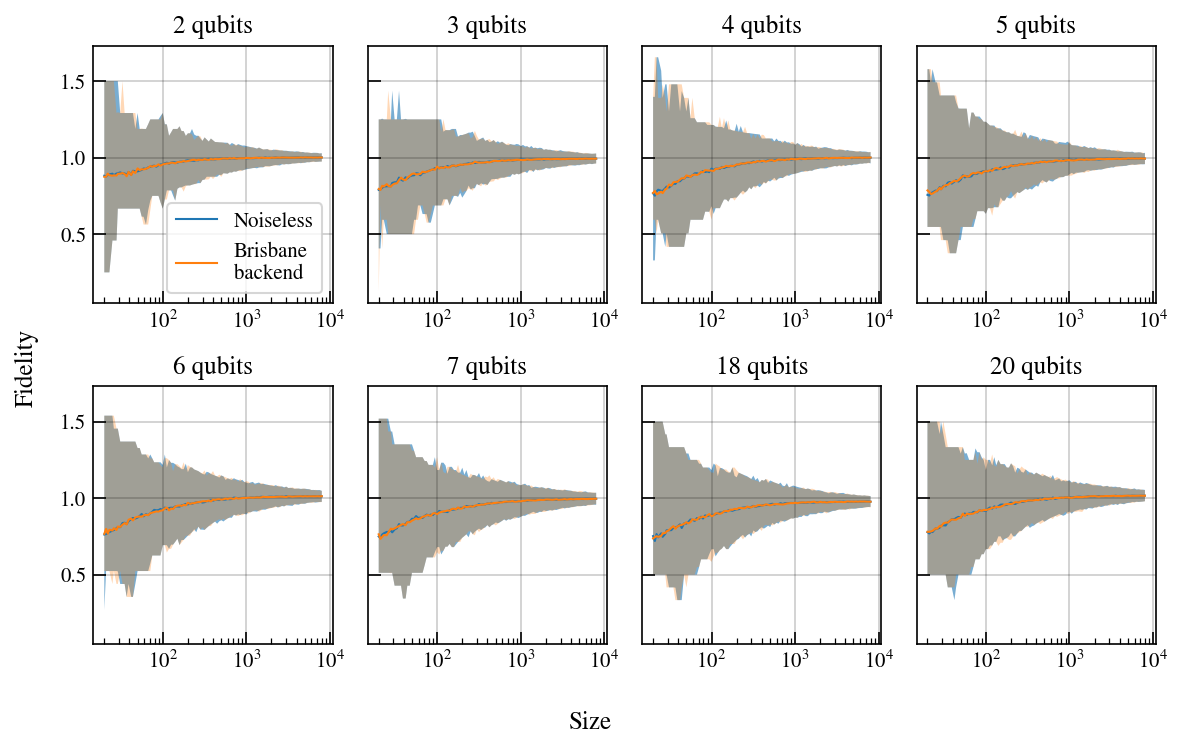

In [336]:
plt.style.use('style_v1.mplstyle')
ncols = len(Range)//2
fig, axs = plt.subplots(2, len(Range)//2, sharey=True, figsize=(8, 5))


for idx, i in enumerate(Range):
    # axs[i-3].plot(sizes, fidelities_noiseless[i], label='Noiseless')
    # axs[i-3].plot(sizes, fidelities_noisy[i], label='Brisbane\nbackend')
    err_noiseless = np.transpose(fidelities_noiseless[i][:, 1:])
    err_noisy =  np.transpose(fidelities_noisy[i][:, 1:])
    # axs[i-3].plot(sizes, fidelities_noiseless[i][:, 0], yerr=err_noiseless, label='Noiseless')
    # axs[i-3].plot(sizes, fidelities_noisy[i][:, 0], yerr=err_noisy, label='Brisbane\nbackend')
    axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noiseless[i][:, 0], label='Noiseless')
    axs[idx//ncols, idx%ncols].plot(sizes, fidelities_noisy[i][:, 0], label='Brisbane\nbackend')

    axs[idx//ncols, idx%ncols].fill_between(sizes, fidelities_noiseless[i][:, 0]-err_noiseless[0, :], fidelities_noiseless[i][:, 0]+err_noiseless[1, :], alpha=0.6)
    axs[idx//ncols, idx%ncols].fill_between(sizes, fidelities_noisy[i][:, 0]-err_noisy[0, :], fidelities_noisy[i][:, 0]+err_noisy[1, :], alpha=0.3)
    
    axs[idx//ncols, idx%ncols].set_title(f'{i} qubits')
    axs[idx//ncols, idx%ncols].set_xscale('log')
    axs[idx//ncols, idx%ncols].grid()

axs[0, 0].legend()
fig.supxlabel('Size')
fig.supylabel('Fidelity')
fig.tight_layout()
fig.savefig('plots/clsh_fidelities.pdf')

In [337]:
super_fid_clsh = {'Noiseless': fidelities_noiseless, 'Brisbane backend': fidelities_noisy}

eps = 0.05
min_size = {}
for name, vals in super_fid_clsh.items():
    tmp_min_size = []
    for k, v in vals.items():
        try:
            idx = np.argwhere(np.abs(np.array(v)-1)<eps)[0][0]
            tmp_min_size.append(sizes[idx])
        except Exception:
            tmp_min_size.append(-1)
    min_size[name] = np.array(tmp_min_size)

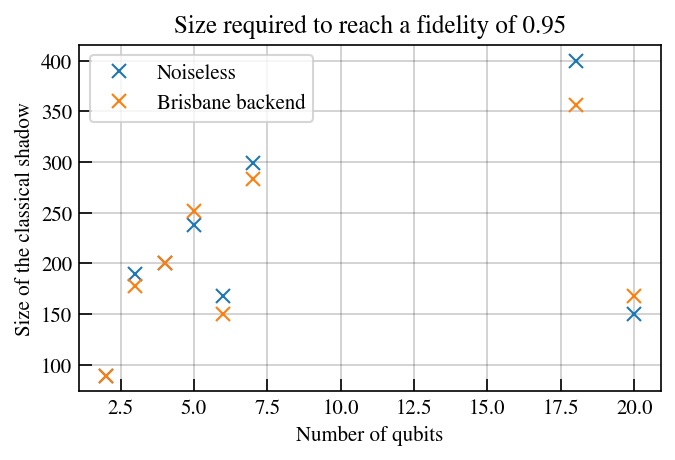

In [339]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
i = 0
for name, vals in min_size.items():
    # fit = np.polyfit(np.arange(3, 7)[vals>0], np.log(vals[vals>0]), 2)
    # x = np.linspace(3, len(vals[vals>0])+1)
    # fit_vals = np.polyval(fit, x)
    plt.plot(Range[vals>0], vals[vals>0], 'x', markersize=7, color=colors[i], label=f'{name}')
    # plt.plot(x, np.exp(fit_vals), ':', markersize=7, color=colors[i])
    i += 1

plt.grid()
plt.title(f'Size required to reach a fidelity of {threshold}')
plt.xlabel('Number of qubits')
plt.ylabel('Size of the classical shadow')
plt.legend()
plt.savefig(f'plots/size_required_{1-eps}.pdf')

# Comparison

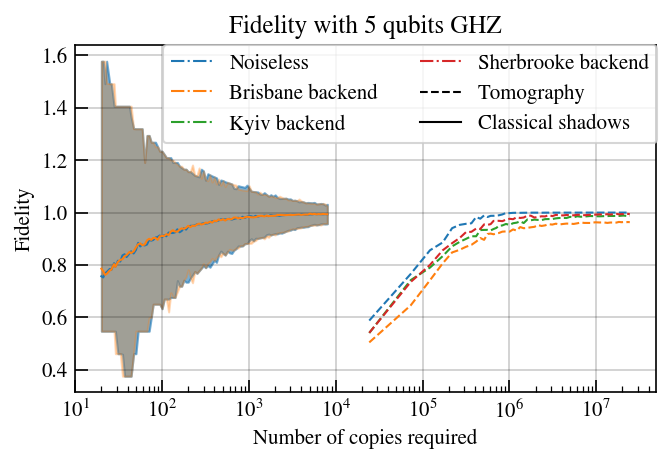

In [349]:
nqubits = 5

i = 0
for name, vals in super_fid_tomo.items():
    plt.semilogx(3**nqubits*nshots[nqubits], vals[nqubits], '--', color=colors[i])#, label=f'{name}')
    plt.semilogx(1e3, 1, '-.', color=colors[i], label=f'{name}' if name!='Noiseless QASM simulator' else 'Noiseless')
    i+=1



i=0
for name, vals in super_fid_clsh.items():
    plt.semilogx(sizes, vals[nqubits][:, 0], '-', color=colors[i])#, label=f'{name}')
    plt.fill_between(sizes, vals[nqubits][:, 0]-vals[nqubits][:, 1], vals[nqubits][:, 0]+vals[nqubits][:, 2], color=colors[i], alpha=0.6 if i==0 else 0.3)
    
    # plt.semilogx(1e3, 0, '-.', color=colors[i], label=f'{name}')
    i+=1



plt.semilogx(1e3, 1, 'k--', label=f'Tomography')
plt.semilogx(1e3, 1, 'k-', label=f'Classical shadows')

plt.title(f'Fidelity with {nqubits} qubits GHZ')
plt.legend(ncols=2, loc='upper right', bbox_to_anchor=(1.02, 1.03))
plt.ylabel('Fidelity')
plt.xlabel('Number of copies required')
plt.grid()
plt.savefig('plots/tomo_vs_clsh.pdf')